<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/DETR_Endovis_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/facebookresearch/detr.git
%cd detr

fatal: destination path 'detr' already exists and is not an empty directory.
/content/detr


In [ ]:
%cd detr

/content/detr


Download pre-trained model

In [ ]:
import gdown

# download model
url = 'https://drive.google.com/uc?id=1S59Aovb4dNOjsu_YdDLxz5wzpxwzww7p'
output = 'eval.zip'
gdown.download(url, output, quiet=True)

!unzip -q eval.zip

replace eval_0049.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
model = torch.load('eval_0049.pth', map_location=torch.device('cpu'))
model.eval();

Download image from Endovis dataset

In [ ]:
url = 'https://drive.google.com/uc?id=1ycUjt29WI4VjK6grZnQXYdzdEuMhpqNA'
gdown.download(url, 'raw_img.jpg', quiet=True)

'raw_img.jpg'

In [ ]:
from PIL import Image
raw_img = Image.open('raw_img.jpg')
raw_img;

Do transformation for the image

In [ ]:

import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
# mean-std normalize the input image (batch-size: 1)
img = transform(raw_img).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.3+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.3

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], raw_img.size)

NameError: ignored

Visualize result

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = ('Bipolar Forceps', 'Prograsp Forceps', 'Large Needle Driver', 'Vessel Sealer',
            'Grasping Retractor', 'Monopolar Curved Scissors', 'Others')

def plot_results(pil_img, prob, boxes):

    print('Save results:')
    img = np.array(pil_img)
    img = (img - img.min()) / (img.max()-img.min())
    font = cv2.FONT_HERSHEY_SIMPLEX

    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS):
        top_corner, down_corner = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        cv2.rectangle(img, top_corner, down_corner, color=c, thickness=4)

        cl = p.argmax()
        text = f'{CLASSES[cl-1]}: {p[cl]:0.2f}'
        cv2.putText(img,str(text),(top_corner[0]+5, top_corner[1]+25), font, 1,c,4,cv2.LINE_AA)

    plt.imshow(img)
    plt.imsave(os.path.join('res.png'), img)
    print(f'Save the result image res.png')
    plt.show()

plot_results(raw_img, probas[keep], bboxes_scaled)

NameError: ignored

In [ ]:
!pwd

/content/detr


Doing above process from scratch

In [ ]:
!pip -q install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Preparing metadata (setup.py) ... done
--2023-08-02 14:09:50--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.248.124, 65.8.248.22, 65.8.248.127, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.248.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  74.3MB/s    in 27s     

2023-08-02 14:10:16 (92.0 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
DETR Transformer class.

Copy-paste from torch.nn.Transformer with modifications:
    * positional encodings are passed in MHattention
    * extra LN at the end of encoder is removed
    * decoder returns a stack of activations from all decoding layers
"""
import copy
from typing import Optional, List

import torch
import torch.nn.functional as F
from torch import nn, Tensor
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

class Transformer(nn.Module):

    def __init__(self, d_model=512, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False,
                 return_intermediate_dec=False):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation, normalize_before)
        encoder_norm = nn.LayerNorm(d_model) if normalize_before else None
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)
        # sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
        # sam = sam_model_registry["vit_b"](checkpoint="../sam_vit_b_01ec64.pth")
        # self.blocks_sam = sam.image_encoder.blocks
        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation, normalize_before)
        decoder_norm = nn.LayerNorm(d_model)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm,
                                          return_intermediate=return_intermediate_dec)

        self._reset_parameters()

        self.d_model = d_model
        self.nhead = nhead

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, mask, query_embed, pos_embed):
        # flatten NxCxHxW to HWxNxC
        bs, c, h, w = src.shape
        src = src.flatten(2).permute(2, 0, 1)
        pos_embed = pos_embed.flatten(2).permute(2, 0, 1)
        query_embed = query_embed.unsqueeze(1).repeat(1, bs, 1)
        mask = mask.flatten(1)

        tgt = torch.zeros_like(query_embed)
        print('bef self.encoder', src.shape)
        memory = self.encoder(src, src_key_padding_mask=mask, pos=pos_embed)
        # memory = self.encoder_sam(src.permute(1,2,0))
        # memory = memory.permute(2,0,1)
        print('aft self.encoder', memory.shape)

        print('decoder input1:tgt', tgt.shape, 'memory:',memory.shape)
        hs = self.decoder(tgt, memory, memory_key_padding_mask=mask,
                          pos=pos_embed, query_pos=query_embed)
        print('Aft self.decoder', src.shape)
        return hs.transpose(1, 2), memory.permute(1, 2, 0).view(bs, c, h, w)


class TransformerEncoder(nn.Module):

    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        sam = sam_model_registry["vit_b"](checkpoint="../sam_vit_b_01ec64.pth")
        self.blocks_sam = sam.image_encoder.blocks
        print('Len',len(self.blocks_sam))

    def forward(self, src,
                mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        output = src
        print('bef encoder layers:', output.shape)
        # for i, layer in enumerate(self.layers):
        #     output = layer(output, src_mask=mask,
        #                    src_key_padding_mask=src_key_padding_mask, pos=pos)
        #     print('Layers:',i, output.shape)# [1280, 1, 256]

        output = output.permute(1,2,0)[:,:,:768]
        for blk in self.blocks_sam:
            output = blk(output)#[1, 64, 64, 768]

        print('after encoder layers:', output.shape)
        if self.norm is not None:
            output = self.norm(output)

        return output


class TransformerDecoder(nn.Module):

    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.return_intermediate = return_intermediate

    def forward(self, tgt, memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                query_pos: Optional[Tensor] = None):
        output = tgt

        intermediate = []
        print('bef encoder layers:', output.shape)
        for layer in self.layers:
            output = layer(output, memory, tgt_mask=tgt_mask,
                           memory_mask=memory_mask,
                           tgt_key_padding_mask=tgt_key_padding_mask,
                           memory_key_padding_mask=memory_key_padding_mask,
                           pos=pos, query_pos=query_pos)
            if self.return_intermediate:
                intermediate.append(self.norm(output))

        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate.pop()
                intermediate.append(output)

        if self.return_intermediate:
            return torch.stack(intermediate)

        return output.unsqueeze(0)


class TransformerEncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward_post(self,
                     src,
                     src_mask: Optional[Tensor] = None,
                     src_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None):
        q = k = self.with_pos_embed(src, pos)
        src2 = self.self_attn(q, k, value=src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

    def forward_pre(self, src,
                    src_mask: Optional[Tensor] = None,
                    src_key_padding_mask: Optional[Tensor] = None,
                    pos: Optional[Tensor] = None):
        src2 = self.norm1(src)
        q = k = self.with_pos_embed(src2, pos)
        src2 = self.self_attn(q, k, value=src2, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src2 = self.norm2(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
        src = src + self.dropout2(src2)
        return src

    def forward(self, src,
                src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        if self.normalize_before:
            return self.forward_pre(src, src_mask, src_key_padding_mask, pos)
        return self.forward_post(src, src_mask, src_key_padding_mask, pos)


class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward_post(self, tgt, memory,
                     tgt_mask: Optional[Tensor] = None,
                     memory_mask: Optional[Tensor] = None,
                     tgt_key_padding_mask: Optional[Tensor] = None,
                     memory_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None,
                     query_pos: Optional[Tensor] = None):
        q = k = self.with_pos_embed(tgt, query_pos)
        tgt2 = self.self_attn(q, k, value=tgt, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt, query_pos),
                                   key=self.with_pos_embed(memory, pos),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

    def forward_pre(self, tgt, memory,
                    tgt_mask: Optional[Tensor] = None,
                    memory_mask: Optional[Tensor] = None,
                    tgt_key_padding_mask: Optional[Tensor] = None,
                    memory_key_padding_mask: Optional[Tensor] = None,
                    pos: Optional[Tensor] = None,
                    query_pos: Optional[Tensor] = None):
        tgt2 = self.norm1(tgt)
        q = k = self.with_pos_embed(tgt2, query_pos)
        tgt2 = self.self_attn(q, k, value=tgt2, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.norm2(tgt)
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt2, query_pos),
                                   key=self.with_pos_embed(memory, pos),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.norm3(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt2))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt

    def forward(self, tgt, memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                query_pos: Optional[Tensor] = None):
        if self.normalize_before:
            return self.forward_pre(tgt, memory, tgt_mask, memory_mask,
                                    tgt_key_padding_mask, memory_key_padding_mask, pos, query_pos)
        return self.forward_post(tgt, memory, tgt_mask, memory_mask,
                                 tgt_key_padding_mask, memory_key_padding_mask, pos, query_pos)


def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def build_transformer(args):
    return Transformer(
        d_model=args.hidden_dim,
        dropout=args.dropout,
        nhead=args.nheads,
        dim_feedforward=args.dim_feedforward,
        num_encoder_layers=args.enc_layers,
        num_decoder_layers=args.dec_layers,
        normalize_before=args.pre_norm,
        return_intermediate_dec=True,
    )


def _get_activation_fn(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return F.relu
    if activation == "gelu":
        return F.gelu
    if activation == "glu":
        return F.glu
    raise RuntimeError(F"activation should be relu/gelu, not {activation}.")

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
from util import box_ops
from util.misc import (NestedTensor, nested_tensor_from_tensor_list,
                       accuracy, get_world_size, interpolate,
                       is_dist_avail_and_initialized)

from models.backbone import build_backbone
from models.matcher import build_matcher
from models.segmentation import (DETRsegm, PostProcessPanoptic, PostProcessSegm,
                           dice_loss, sigmoid_focal_loss)
# from models.transformer import build_transformer

# class DETR(nn.Module):
#     """ This is the DETR module that performs object detection """
#     def __init__(self, backbone, transformer, num_classes, num_queries, aux_loss=False):
#         """ Initializes the model.
#         Parameters:
#             backbone: torch module of the backbone to be used. See backbone.py
#             transformer: torch module of the transformer architecture. See transformer.py
#             num_classes: number of object classes
#             num_queries: number of object queries, ie detection slot. This is the maximal number of objects
#                          DETR can detect in a single image. For COCO, we recommend 100 queries.
#             aux_loss: True if auxiliary decoding losses (loss at each decoder layer) are to be used.
#         """
#         super().__init__()
#         self.num_queries = num_queries
#         self.transformer = transformer
#         hidden_dim = transformer.d_model
#         self.class_embed = nn.Linear(hidden_dim, num_classes + 1)
#         self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
#         self.query_embed = nn.Embedding(num_queries, hidden_dim)
#         self.input_proj = nn.Conv2d(backbone.num_channels, hidden_dim, kernel_size=1)
#         self.backbone = backbone
#         self.aux_loss = aux_loss

#     def forward(self, samples: NestedTensor):
#         """ The forward expects a NestedTensor, which consists of:
#                - samples.tensor: batched images, of shape [batch_size x 3 x H x W]
#                - samples.mask: a binary mask of shape [batch_size x H x W], containing 1 on padded pixels

#             It returns a dict with the following elements:
#                - "pred_logits": the classification logits (including no-object) for all queries.
#                                 Shape= [batch_size x num_queries x (num_classes + 1)]
#                - "pred_boxes": The normalized boxes coordinates for all queries, represented as
#                                (center_x, center_y, height, width). These values are normalized in [0, 1],
#                                relative to the size of each individual image (disregarding possible padding).
#                                See PostProcess for information on how to retrieve the unnormalized bounding box.
#                - "aux_outputs": Optional, only returned when auxilary losses are activated. It is a list of
#                                 dictionnaries containing the two above keys for each decoder layer.
#         """
#         if isinstance(samples, (list, torch.Tensor)):
#             samples = nested_tensor_from_tensor_list(samples)
#         features, pos = self.backbone(samples)
#         print(type(features), len(features))
#         print('pos:', torch.stack(pos).shape)
#         src, mask = features[-1].decompose()
#         print('features src:', src.shape, 'features mask:', mask.shape)
#         assert mask is not None
#         hs = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])[0]
#         print('hs', hs.shape)
#         outputs_class = self.class_embed(hs)
#         outputs_coord = self.bbox_embed(hs).sigmoid()
#         out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
#         if self.aux_loss:
#             out['aux_outputs'] = self._set_aux_loss(outputs_class, outputs_coord)
#         return out

#     @torch.jit.unused
#     def _set_aux_loss(self, outputs_class, outputs_coord):
#         # this is a workaround to make torchscript happy, as torchscript
#         # doesn't support dictionary with non-homogeneous values, such
#         # as a dict having both a Tensor and a list.
#         return [{'pred_logits': a, 'pred_boxes': b}
#                 for a, b in zip(outputs_class[:-1], outputs_coord[:-1])]


class SetCriterion(nn.Module):
    """ This class computes the loss for DETR.
    The process happens in two steps:
        1) we compute hungarian assignment between ground truth boxes and the outputs of the model
        2) we supervise each pair of matched ground-truth / prediction (supervise class and box)
    """
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        """ Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            matcher: module able to compute a matching between targets and proposals
            weight_dict: dict containing as key the names of the losses and as values their relative weight.
            eos_coef: relative classification weight applied to the no-object category
            losses: list of all the losses to be applied. See get_loss for list of available losses.
        """
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        if log:
            # TODO this should probably be a separate loss, not hacked in this one here
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
        return losses

    @torch.no_grad()
    def loss_cardinality(self, outputs, targets, indices, num_boxes):
        """ Compute the cardinality error, ie the absolute error in the number of predicted non-empty boxes
        This is not really a loss, it is intended for logging purposes only. It doesn't propagate gradients
        """
        pred_logits = outputs['pred_logits']
        device = pred_logits.device
        tgt_lengths = torch.as_tensor([len(v["labels"]) for v in targets], device=device)
        # Count the number of predictions that are NOT "no-object" (which is the last class)
        card_pred = (pred_logits.argmax(-1) != pred_logits.shape[-1] - 1).sum(1)
        card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
        losses = {'cardinality_error': card_err}
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
           targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
           The target boxes are expected in format (center_x, center_y, w, h), normalized by the image size.
        """
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(box_ops.generalized_box_iou(
            box_ops.box_cxcywh_to_xyxy(src_boxes),
            box_ops.box_cxcywh_to_xyxy(target_boxes)))
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def loss_masks(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the masks: the focal loss and the dice loss.
           targets dicts must contain the key "masks" containing a tensor of dim [nb_target_boxes, h, w]
        """
        assert "pred_masks" in outputs

        src_idx = self._get_src_permutation_idx(indices)
        tgt_idx = self._get_tgt_permutation_idx(indices)
        src_masks = outputs["pred_masks"]
        src_masks = src_masks[src_idx]
        masks = [t["masks"] for t in targets]
        # TODO use valid to mask invalid areas due to padding in loss
        target_masks, valid = nested_tensor_from_tensor_list(masks).decompose()
        target_masks = target_masks.to(src_masks)
        target_masks = target_masks[tgt_idx]

        # upsample predictions to the target size
        src_masks = interpolate(src_masks[:, None], size=target_masks.shape[-2:],
                                mode="bilinear", align_corners=False)
        src_masks = src_masks[:, 0].flatten(1)

        target_masks = target_masks.flatten(1)
        target_masks = target_masks.view(src_masks.shape)
        losses = {
            "loss_mask": sigmoid_focal_loss(src_masks, target_masks, num_boxes),
            "loss_dice": dice_loss(src_masks, target_masks, num_boxes),
        }
        return losses

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'cardinality': self.loss_cardinality,
            'boxes': self.loss_boxes,
            'masks': self.loss_masks
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):
        """ This performs the loss computation.
        Parameters:
             outputs: dict of tensors, see the output specification of the model for the format
             targets: list of dicts, such that len(targets) == batch_size.
                      The expected keys in each dict depends on the losses applied, see each loss' doc
        """
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}

        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_boxes)
        num_boxes = torch.clamp(num_boxes / get_world_size(), min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        # In case of auxiliary losses, we repeat this process with the output of each intermediate layer.
        if 'aux_outputs' in outputs:
            for i, aux_outputs in enumerate(outputs['aux_outputs']):
                indices = self.matcher(aux_outputs, targets)
                for loss in self.losses:
                    if loss == 'masks':
                        # Intermediate masks losses are too costly to compute, we ignore them.
                        continue
                    kwargs = {}
                    if loss == 'labels':
                        # Logging is enabled only for the last layer
                        kwargs = {'log': False}
                    l_dict = self.get_loss(loss, aux_outputs, targets, indices, num_boxes, **kwargs)
                    l_dict = {k + f'_{i}': v for k, v in l_dict.items()}
                    losses.update(l_dict)

        return losses


class PostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, outputs, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = F.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # convert to [x0, y0, x1, y1] format
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        boxes = boxes * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results


class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x


def build(args):
    # the `num_classes` naming here is somewhat misleading.
    # it indeed corresponds to `max_obj_id + 1`, where max_obj_id
    # is the maximum id for a class in your dataset. For example,
    # COCO has a max_obj_id of 90, so we pass `num_classes` to be 91.
    # As another example, for a dataset that has a single class with id 1,
    # you should pass `num_classes` to be 2 (max_obj_id + 1).
    # For more details on this, check the following discussion
    # https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223
    num_classes = 20 if args.dataset_file != 'coco' else 8
    if args.dataset_file == "coco_panoptic":
        # for panoptic, we just add a num_classes that is large enough to hold
        # max_obj_id + 1, but the exact value doesn't really matter
        num_classes = 250
    device = torch.device(args.device)

    backbone = build_backbone(args)

    transformer = build_transformer(args)
    model = DETR(
        backbone,
        transformer,
        num_classes=num_classes,
        num_queries=args.num_queries,
        aux_loss=args.aux_loss,
    )
    if args.masks:
        model = DETRsegm(model, freeze_detr=(args.frozen_weights is not None))
    matcher = build_matcher(args)
    weight_dict = {'loss_ce': 1, 'loss_bbox': args.bbox_loss_coef}
    weight_dict['loss_giou'] = args.giou_loss_coef
    if args.masks:
        weight_dict["loss_mask"] = args.mask_loss_coef
        weight_dict["loss_dice"] = args.dice_loss_coef
    # TODO this is a hack
    if args.aux_loss:
        aux_weight_dict = {}
        for i in range(args.dec_layers - 1):
            aux_weight_dict.update({k + f'_{i}': v for k, v in weight_dict.items()})
        weight_dict.update(aux_weight_dict)

    losses = ['labels', 'boxes', 'cardinality']
    if args.masks:
        losses += ["masks"]
    criterion = SetCriterion(num_classes, matcher=matcher, weight_dict=weight_dict,
                             eos_coef=args.eos_coef, losses=losses)
    criterion.to(device)
    postprocessors = {'bbox': PostProcess()}
    if args.masks:
        postprocessors['segm'] = PostProcessSegm()
        if args.dataset_file == "coco_panoptic":
            is_thing_map = {i: i <= 90 for i in range(201)}
            postprocessors["panoptic"] = PostProcessPanoptic(is_thing_map, threshold=0.85)

    return model, criterion, postprocessors

class DETR(nn.Module):
    """ This is the DETR module that performs object detection """
    def __init__(self, backbone, transformer, num_classes, num_queries, aux_loss=False):
        """ Initializes the model.
        Parameters:
            backbone: torch module of the backbone to be used. See backbone.py
            transformer: torch module of the transformer architecture. See transformer.py
            num_classes: number of object classes
            num_queries: number of object queries, ie detection slot. This is the maximal number of objects
                         DETR can detect in a single image. For COCO, we recommend 100 queries.
            aux_loss: True if auxiliary decoding losses (loss at each decoder layer) are to be used.
        """
        super().__init__()
        self.num_queries = num_queries
        self.transformer = transformer
        hidden_dim = transformer.d_model
        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        self.input_proj = nn.Conv2d(backbone.num_channels, hidden_dim, kernel_size=1)
        self.backbone = backbone
        self.aux_loss = aux_loss
        # sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
        # self.encoder_sam = sam.image_encoder

    def forward(self, samples: NestedTensor):
        """ The forward expects a NestedTensor, which consists of:
               - samples.tensor: batched images, of shape [batch_size x 3 x H x W]
               - samples.mask: a binary mask of shape [batch_size x H x W], containing 1 on padded pixels

            It returns a dict with the following elements:
               - "pred_logits": the classification logits (including no-object) for all queries.
                                Shape= [batch_size x num_queries x (num_classes + 1)]
               - "pred_boxes": The normalized boxes coordinates for all queries, represented as
                               (center_x, center_y, height, width). These values are normalized in [0, 1],
                               relative to the size of each individual image (disregarding possible padding).
                               See PostProcess for information on how to retrieve the unnormalized bounding box.
               - "aux_outputs": Optional, only returned when auxilary losses are activated. It is a list of
                                dictionnaries containing the two above keys for each decoder layer.
        """
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)
        # sam_encoder_out = self.encoder_sam(samples.tensors)
        # print('sam_encoder_out:', sam_encoder_out.shape)
        print('samples:',samples.tensors.shape)
        features, pos = self.backbone(samples)
        print('features', features[0].tensors.shape)#[1, 2048, 32, 40]
        print('pos:', torch.stack(pos).shape)#[1, 1, 256, 32, 40]
        src, mask = features[-1].decompose()
        print('features src:', src.shape, 'features mask:', mask.shape)
        assert mask is not None
        print('Transformer inputs', 'self.input_proj(src):', self.input_proj(src).shape, 'mask',mask.shape, 'embed weight:', self.query_embed.weight.shape, 'pos[-1]:', pos[-1].shape)
        hs = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])[0]
        print('Transformer outputs', hs.shape)
        outputs_class = self.class_embed(hs)
        print('outputs_class', outputs_class.shape)
        outputs_coord = self.bbox_embed(hs).sigmoid()
        print('outputs_coord', outputs_coord.shape)
        out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
        # if self.aux_loss:
        #     out['aux_outputs'] = self._set_aux_loss(outputs_class, outputs_coord)
        return out

In [ ]:
import argparse
from main import get_args_parser
from PIL import Image
# from models import build_model
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def main():
    parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
    args = parser.parse_args([])
    args.aux_loss = False
    args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(args.device)
    model, criterion, postprocessors = build(args)
    model.to(device)
    # model.load_state_dict(torch.load('eval_0049.pth', map_location=torch.device('cpu')).state_dict())
    # model = torch.load('eval_0049.pth', map_location=torch.device('cpu'))
    model.eval();

    raw_img = Image.open('raw_img.jpg')
    img = transform(raw_img).unsqueeze(0)
    outputs = model(img)
    print('outputs[pred_logits]:', outputs['pred_logits'].shape)
main()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Len 12
samples: torch.Size([1, 3, 1024, 1280])
features torch.Size([1, 2048, 32, 40])
pos: torch.Size([1, 1, 256, 32, 40])
features src: torch.Size([1, 2048, 32, 40]) features mask: torch.Size([1, 32, 40])
Transformer inputs self.input_proj(src): torch.Size([1, 256, 32, 40]) mask torch.Size([1, 32, 40]) embed weight: torch.Size([100, 256]) pos[-1]: torch.Size([1, 256, 32, 40])
bef self.encoder torch.Size([1280, 1, 256])
bef encoder layers: torch.Size([1280, 1, 256])


ValueError: ignored

In [ ]:
DeTR:
bef encoder layers: torch.Size([1280, 1, 256])
Layers: 0 torch.Size([1280, 1, 256])
Layers: 1 torch.Size([1280, 1, 256])
Layers: 2 torch.Size([1280, 1, 256])
Layers: 3 torch.Size([1280, 1, 256])
Layers: 4 torch.Size([1280, 1, 256])
Layers: 5 torch.Size([1280, 1, 256])
after encoder layers: torch.Size([1280, 1, 256])

SAM:
torch.Size([1, 3, 1024, 1024])
number of encoder bloaks: 12
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
torch.Size([1, 256, 64, 64])

In [ ]:
from torchvision.models import resnet18, resnet34, resnet101#18:[1, 49, 512], 34:[1, 49, 512], 101:[1, 49, 2048]
transform = T.Compose([
    T.ToTensor(),
    T.Resize((256, 256)),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

raw_img = Image.open('raw_img.jpg')
img = transform(raw_img).unsqueeze(0)
model_visual_feat = resnet18(pretrained=True)
# model_visual_feat = resnet34(pretrained=True)
model_visual_feat.avgpool = nn.Identity()
model_visual_feat.fc = nn.Identity()
model_visual_feat.eval()
visual_embeds = model_visual_feat(img).view(1, 49, 512)
print(visual_embeds.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils

RuntimeError: ignored

In [ ]:
import numpy as np
49 * 768, np.sqrt(512)

(37632, 22.627416997969522)

In [ ]:
/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/image_encoder.py

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth

--2023-08-02 15:35:38--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.248.127, 65.8.248.22, 65.8.248.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.248.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1249524607 (1.2G) [binary/octet-stream]
Saving to: ‘sam_vit_l_0b3195.pth’

sam_vit_l_0b3195.pt 100%[===================>]   1.16G   100MB/s    in 14s     

2023-08-02 15:35:52 (83.9 MB/s) - ‘sam_vit_l_0b3195.pth’ saved [1249524607/1249524607]



In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-08-02 15:37:06--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.248.127, 65.8.248.124, 65.8.248.22, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.248.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   124MB/s    in 2.9s    

2023-08-02 15:37:09 (124 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [ ]:
%cd /content

/content


In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image
# sam = sam_model_registry["vit_h"](checkpoint="detr/sam_vit_h_4b8939.pth")
# sam = sam_model_registry["vit_l"](checkpoint="sam_vit_l_0b3195.pth")
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
# class SAM_Encoder(nn.Module):
#     def __init__(self,):
#         self.sam_encoder = sam.image_encoder

#     def forward(self, img):
#         out = self.sam_encoder(img)
#         print(out.shape)
#         return out

# model_sam = SAM_Encoder()
# model_sam.eval()


In [ ]:
import torchvision.transforms as T
import torch

transform = T.Compose([
    T.ToTensor(),
    T.Resize((1024, 1024)),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

raw_img = Image.open('detr/raw_img.jpg')
img = transform(raw_img).unsqueeze(0)
print(img.shape)
sam.eval()
with torch.no_grad():
    sam_out = sam.image_encoder(img)

print(sam_out.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 3, 1024, 1024])
number of encoder bloaks: 12
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
blk: torch.Size([1, 64, 64, 768])
torch.Size([1, 256, 64, 64])


In [ ]:
/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/image_encoder.py
/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/sam.py

vit_l:
number of encoder bloaks: 24
torch.Size([1, 256, 64, 64])

vit_b:
number of encoder bloaks: 12
torch.Size([1, 256, 64, 64])

torch.Size([1, 256, 64, 64])

In [ ]:
64*64

4096

In [ ]:
bef self.encoder torch.Size([1280, 1, 256])
aft self.encoder torch.Size([1280, 1, 256])
hs torch.Size([6, 1, 100, 256])
outputs[pred_logits]: torch.Size([1, 100, 9])

In [ ]:
model.transformer

In [ ]:
parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
args = parser.parse_args([])
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(args.device)
model, criterion, postprocessors = build(args)
model

hs torch.Size([6, 1, 100, 256])
Save results:
Save the result image res.png


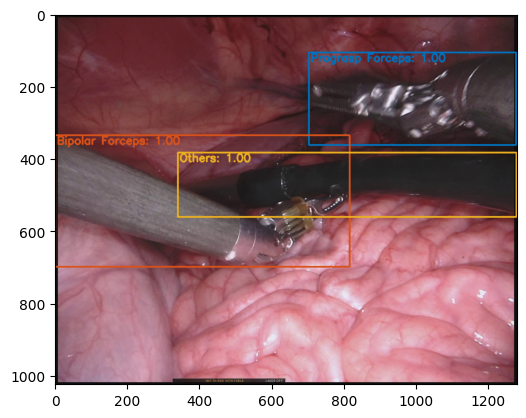

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# mean-std normalize the input image (batch-size: 1)
img = transform(raw_img).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.3+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.3

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], raw_img.size)


COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = ('Bipolar Forceps', 'Prograsp Forceps', 'Large Needle Driver', 'Vessel Sealer',
            'Grasping Retractor', 'Monopolar Curved Scissors', 'Others')

def plot_results(pil_img, prob, boxes):

    print('Save results:')
    img = np.array(pil_img)
    img = (img - img.min()) / (img.max()-img.min())
    font = cv2.FONT_HERSHEY_SIMPLEX

    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS):
        top_corner, down_corner = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        cv2.rectangle(img, top_corner, down_corner, color=c, thickness=4)

        cl = p.argmax()
        text = f'{CLASSES[cl-1]}: {p[cl]:0.2f}'
        cv2.putText(img,str(text),(top_corner[0]+5, top_corner[1]+25), font, 1,c,4,cv2.LINE_AA)

    plt.imshow(img)
    plt.imsave(os.path.join('res.png'), img)
    print(f'Save the result image res.png')
    plt.show()

plot_results(raw_img, probas[keep], bboxes_scaled)

In [ ]:
for name, param in mod.named_parameters():
    print(name, param.shape)

transformer.encoder.layers.0.self_attn.in_proj_weight torch.Size([768, 256])
transformer.encoder.layers.0.self_attn.in_proj_bias torch.Size([768])
transformer.encoder.layers.0.self_attn.out_proj.weight torch.Size([256, 256])
transformer.encoder.layers.0.self_attn.out_proj.bias torch.Size([256])
transformer.encoder.layers.0.linear1.weight torch.Size([2048, 256])
transformer.encoder.layers.0.linear1.bias torch.Size([2048])
transformer.encoder.layers.0.linear2.weight torch.Size([256, 2048])
transformer.encoder.layers.0.linear2.bias torch.Size([256])
transformer.encoder.layers.0.norm1.weight torch.Size([256])
transformer.encoder.layers.0.norm1.bias torch.Size([256])
transformer.encoder.layers.0.norm2.weight torch.Size([256])
transformer.encoder.layers.0.norm2.bias torch.Size([256])
transformer.encoder.layers.1.self_attn.in_proj_weight torch.Size([768, 256])
transformer.encoder.layers.1.self_attn.in_proj_bias torch.Size([768])
transformer.encoder.layers.1.self_attn.out_proj.weight torch.Siz